In [56]:
from TicTacToeEnv import TicTacToeAdvanced
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.distributions import Categorical
import random

In [122]:
class PPO(nn.Module):
    def __init__(self, state_dim, action_dim, gamma=0.99, batch_size=128, 
                 epsilon=0.2, epoch_n=100, pi_lr=1e-4, v_lr=1e-3):

        super().__init__()
        
        self.action_dim = action_dim
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.pi_model_base = nn.Sequential(nn.Linear(state_dim, 256), nn.LeakyReLU(0.1),
                                           nn.Linear(256, 256), nn.LeakyReLU(0.1),
                                           nn.Linear(256, 256), nn.LeakyReLU(0.1),
                                      nn.Linear(256, 256), nn.LeakyReLU(0.1)).to(self.device)
        self.pi_model_m = nn.Sequential(nn.Linear(256, action_dim), nn.Softmax()).to(self.device)
        
        self.gamma = gamma
        self.batch_size = batch_size
        self.l_epsilon = 1
        self.epsilon = epsilon
        self.epoch_n = epoch_n
        self.pi_optimizer = torch.optim.Adam(
            list(self.pi_model_base.parameters())+list(self.pi_model_m.parameters()),
            lr=pi_lr)
        
    def forward_pi(self, state):
        x = self.pi_model_base(state)
        
        return self.pi_model_m(x)

    def get_action(self, state, rand_factor = 1):
        logits = self.forward_pi(torch.FloatTensor(state))
        norm = torch.ones((self.action_dim,))/self.action_dim
        logits_ = (1-self.l_epsilon)*logits + self.l_epsilon*norm
        dist = Categorical(logits_)
        action = dist.sample()
        return action.numpy()
    
    def to_cpu(self):
        self.pi_model_base.to('cpu')
        self.pi_model_m.to('cpu')
        
    def to_dev(self):
        self.pi_model_base.to(self.device)
        self.pi_model_m.to(self.device)

    def fit(self, states, actions, rewards, dones):
        
        states, actions, rewards, dones = map(np.array, [states, actions, rewards, dones])
        rewards, dones = rewards.reshape(-1, 1), dones.reshape(-1, 1)

        returns = np.zeros(rewards.shape)
        returns[-1] = rewards[-1]
        for t in range(returns.shape[0] - 2, -1, -1):
            returns[t] = rewards[t] + (1 - dones[t]) * self.gamma * returns[t + 1]
        for t in range(returns.shape[0]):
            if returns[t] < 0:
                returns[t] *= 0.8

        states, actions, returns = map(torch.FloatTensor, [states, actions, returns])
        states, actions, returns = states.to(self.device), actions.to(self.device), returns.to(self.device)

        logits = self.forward_pi(states)
        norm = (torch.ones((self.action_dim,))/self.action_dim).to(self.device)
        logits_ = (1-self.l_epsilon)*logits + self.l_epsilon*norm
        dist = Categorical(logits_)
        old_log_probs = dist.log_prob(actions).detach()

        for epoch in range(self.epoch_n):
            
            idxs = np.random.permutation(returns.shape[0])
            for i in range(0, returns.shape[0], self.batch_size):
                b_idxs = idxs[i: i + self.batch_size]
                b_states = states[b_idxs]
                b_actions = actions[b_idxs]
                b_returns = returns[b_idxs]
                b_old_log_probs = old_log_probs[b_idxs]
    
                b_advantage = b_returns.detach()
                
                b_logits = self.forward_pi(b_states)
                b_dist = Categorical(b_logits)
                b_new_log_probs = b_dist.log_prob(b_actions)
    
                b_ratio = torch.exp(b_new_log_probs - b_old_log_probs)
                pi_loss_1 = b_ratio * b_advantage.detach()
                pi_loss_2 = torch.clamp(b_ratio, 1. - self.epsilon,  1. + self.epsilon) * b_advantage.detach()
                pi_loss = - torch.mean(torch.min(pi_loss_1, pi_loss_2))
                
                pi_loss.backward()
                self.pi_optimizer.step()
                self.pi_optimizer.zero_grad()
                

In [123]:
def validate(env, agent, runs=100, agent2 = None):
    s = 0
    for i in range(runs):
        s+=butle(env,agent,is_agent_first = True)
    for i in range(runs):
        s+=butle(env,agent,is_agent_first = False)
    return s/2/runs
        

def butle(env, agent, agent2 = None, is_agent_first = True):
    done = False
    state = env.reset()
    t = 0
    agent.l_epsilon = 0
    while not done:
        if t%2 == (is_agent_first+1)%2:
            state = state.reshape(-1)
            logits = agent.forward_pi(torch.FloatTensor(state*(-1)**(t%2+1)))
            action = np.argmax(logits.detach().numpy())
            state, reward, done, correct = env.step(action)
            if done:
                return reward
        else:
            state = state.reshape(-1)
            if agent2 == None:
                action = np.random.randint(agent.action_dim)
            else:
                logits = agent2.forward_pi(torch.FloatTensor(state*(-1)**(t%2+1)))
                action = np.argmax(logits.detach().numpy())
            state, reward, done, correct = env.step(action)
            if done:
                return -reward
        t+=1

In [124]:
env = TicTacToeAdvanced()

In [125]:
%%time

state_dim = env.observation_space[0]**2
action_dim = env.action_space['n']
print(action_dim)

agent = PPO(state_dim, action_dim, gamma=-0.95)

total_rewards = []
validation = []
wins = []

5
CPU times: total: 0 ns
Wall time: 6.1 ms


In [129]:
%%time

episode_n = 300
trajectory_n = 50

for episode in range(episode_n):

    states, actions, rewards, dones = [], [], [], []
    
    agent.to_cpu()
    for _ in range(trajectory_n):
        total_reward = 0

        state = env.reset()
        state = state.reshape(-1)
        for t in range(30):
            states.append(state*(-1)**(t%2+1))
            
            action = agent.get_action(state*(-1)**(t%2+1))
            actions.append(action)
            
            state, reward, done, correct = env.step(action)
            state = state.reshape(-1)
            rewards.append(reward)
            dones.append(done)

            total_reward += reward
            if done:
                if reward>0:
                    wins.append(state)
                break
            
        total_rewards.append(total_reward)
    if(episode%10==0):
        validation.append(validate(env,agent,100))
    agent.to_dev()
    agent.fit(states, actions, rewards, dones)
    agent.l_epsilon -= 0.015
    if agent.l_epsilon <= 0.15:
        agent.l_epsilon = 0.15
    
    print(episode,validation[-1],end='\r')

KeyboardInterrupt: 

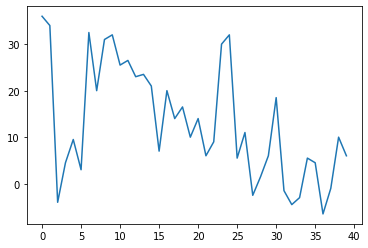

In [130]:
plt.plot(validation)

In [146]:
agent.l_epsilon = 0.15

In [131]:
done = False
state = env.reset()
env.render()
t = 0
agent.l_epsilon = 0
agent.to_cpu()
while not done:
    if t%2 == 0:
        state = state.reshape(-1)
        logits = agent.forward_pi(torch.FloatTensor(state*(-1)**(t%2+1)))
        print(logits)
        action = agent.get_action(state*(-1)**(t%2+1))
        print(np.argmax(logits.detach().numpy()),action)
        state, reward, done, correct = env.step(np.argmax(logits.detach().numpy()))
        print(reward)
        env.render()
        if done:
            print("ROBOT WIN")
    else:
        action = int(input(f'{env.player_index}-th player turn to act (enter number from 1 to {env.n})')) - 1
        state, reward, done, correct = env.step(action)
        print(reward)
        env.render()
        if done:
            print("YOU WIN")
    t+=1

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
tensor([0.1106, 0.2159, 0.1560, 0.3230, 0.1946], grad_fn=<SoftmaxBackward0>)
3 3
0
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.]]
1-th player turn to act (enter number from 1 to 5)1
0
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 1.  0.  0. -1.  0.]]
tensor([0.0778, 0.2009, 0.1065, 0.1829, 0.4319], grad_fn=<SoftmaxBackward0>)
4 4
0
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 1.  0.  0. -1. -1.]]
1-th player turn to act (enter number from 1 to 5)1
0
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0. -1. -1.]]
tensor([0.0899, 0.3547, 0.2598, 0.1605, 0.1351], grad_fn=<SoftmaxBackward0>)
1 3
0
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  

In [ ]:
done = False
state = env.reset()
env.render()
while not done:
    action = int(input(f'{env.player_index}-th player turn to act (enter number from 1 to {env.n})')) - 1
    state, reward, done, correct = env.step(action)
    print(reward)
    env.render()

In [15]:
done = False
state = env.reset()
t = 0
while not done:
    print(state*(-1)**(t%2+1))
    state = state.reshape(-1)
    action = agent.get_action(state)
    state, reward, done, correct = env.step(action)
    print(reward,done,(-1)**(t%2+1))
    t+=1

[[-0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0.]]
0 False -1
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.]]
0 False 1
[[-0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0.]
 [-0. -0. -1. -0.  1.]]
0 False -1
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.]
 [ 0.  0.  1.  0. -1.]]
0 False 1
[[-0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0.]
 [-0. -0. -0. -0.  1.]
 [-0. -1. -1. -0.  1.]]
0 False -1
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.]
 [-1.  1.  1.  0. -1.]]
0 False 1
[[-0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -1.]
 [-0. -0. -0. -0.  1.]
 [ 1. -1. -1. -0.  1.]]
0 False -1
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0. -1.]
 [-1.  1.  1. -1. -1.]

In [113]:
np.random.randint(4)

3

In [115]:
False+1

1

In [53]:
i = 10
print(states[i].reshape(5,5))
print(actions[i])
print(states[i+1].reshape(5,5))
print(wins[100].reshape(5,5))

[[-0. -0. -0. -0. -0.]
 [-0. -0. -0. -1. -0.]
 [-1.  1. -0. -1. -0.]
 [-1.  1. -0.  1. -0.]
 [ 1.  1. -0. -1. -0.]]
0
[[ 0.  0.  0.  0.  0.]
 [-1.  0.  0.  1.  0.]
 [ 1. -1.  0.  1.  0.]
 [ 1. -1.  0. -1.  0.]
 [-1. -1.  0.  1.  0.]]
[[ 0. -1.  0.  0.  0.]
 [ 0.  1.  0. -1.  0.]
 [ 1. -1.  0.  1.  0.]
 [-1.  1.  1.  1.  0.]
 [ 1. -1. -1. -1. -1.]]


In [76]:
len(wins)

886

In [60]:
net = nn.Sequential(nn.Linear(25, 256), nn.LeakyReLU(0.1),
                nn.Linear(256, 256), nn.LeakyReLU(0.1),
                nn.Linear(256, 256), nn.LeakyReLU(0.1),
                nn.Linear(256, 256), nn.LeakyReLU(0.1),
                nn.Linear(256, 1))

In [64]:
net(torch.FloatTensor(wins[1:4]))

tensor([[ 0.0047],
        [-0.0136],
        [-0.0080]], grad_fn=<AddmmBackward0>)

In [85]:
train_data = wins[:int(len(wins)*2/3)]
print(int(len(wins)*2/3))
not_wins = states[np.array(dones) == False]
print(np.array(dones))
print(len(dones))
idxs = np.random.permutation(len(not_wins))
not_wins = not_wins[idxs]

print(int(len(wins)))
print(int(len(wins)*2/3))
print(len(not_wins[:int(len(wins)*2/3)]))
train_data.extend(not_wins[:int(len(wins)*2/3)])

print(len(train_data))    

590


TypeError: only integer scalar arrays can be converted to a scalar index